In [1]:
#!/usr/bin/env python
# coding: utf-8
import re
import sys
import pandas as pd
import sys
import ast
import matplotlib.pyplot as plt
import os
import time

run_command="/opt/jdk-14/bin/java -Dfile.encoding=UTF-8 -classpath /media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/out/production/iFogSim2:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-3.0.3-sources.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-3.0.3.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-examples-3.0.3-sources.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-examples-3.0.3.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/commons-math3-3.5/commons-math3-3.5.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/guava-18.0.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/json-simple-1.1.1.jar org.fog.test.perfeval."
_app_name="TwoDCNSApps"
_report_path="Report_Saeedeh/t_pandas.txt"
_save_path="Report_Saeedeh/Pandas"


In [2]:
def run(app_name="TwoDCNSApps", scenario="Router_Proxy", report_path=_report_path): 
    cmd=f'{run_command}{app_name} {scenario} | tee -a {report_path}'
    os.system(cmd)

In [3]:
# init
global Scenario
Scenario=None
# Initialize and maintain other DataFrames as global variables
if 'computation_energy_per_vm_df' not in globals():
    computation_energy_per_vm_df = pd.DataFrame(columns=['scenario','device', 'app', 'vm', 'energy'])

if 'computation_energy_df' not in globals():
    computation_energy_df = pd.DataFrame(columns=['scenario','device', 'energy'])

if 'communication_energy_df' not in globals():
    communication_energy_df = pd.DataFrame(columns=['scenario','device_id', 'device', 'tuple', 'energy'])

if 'execution_time_df' not in globals():
    execution_time_df = pd.DataFrame(columns=['scenario','tuple', 'execution_time'])

if 'simulation_time_df' not in globals():
    simulation_time_df = pd.DataFrame(columns=['scenario', 'simulation_time'])

In [4]:
# reset: remove report and clear dfs
def _reset():
    os.system(f'rm {_report_path}')
    computation_energy_per_vm_df = pd.DataFrame(columns=['scenario','device', 'app', 'vm', 'energy'])
    computation_energy_df = pd.DataFrame(columns=['scenario','device', 'energy'])
    communication_energy_df = pd.DataFrame(columns=['scenario','device_id', 'device', 'tuple', 'energy'])
    execution_time_df = pd.DataFrame(columns=['scenario','tuple', 'execution_time'])
    simulation_time_df = pd.DataFrame(columns=['scenario', 'simulation_time'])
    time.sleep(3)

In [5]:
computation_energy_per_vm_df

,scenario,device,app,vm,energy


In [6]:
# Parsing Functions
# string map to map
def parse_map_string(sample):
    # Use regex to convert the string into a valid JSON format
    formatted_sample = re.sub(r'(\w+)=', r'"\1":', sample)
    formatted_sample = re.sub(r'(\w+)(?==)', r'"\1"', formatted_sample)

    # Parse the formatted string into a dictionary
    parsed_sample = ast.literal_eval(formatted_sample)

    #print(parsed_sample)
    return parsed_sample

# For this format:
def parse_vm_energy(l):
    global computation_energy_per_vm_df
    #l="cloud : Vms Energy Map of device : cloud {dcns_1={user_interface_1=12823.499999997002}, dcns_0={user_interface=13373.078571425585}}"
    pattern = r'^(.*?): Vms Energy Map of device : (.*?) ({.*?})$'  # Adjusted pattern
    # Match the pattern with the line
    match = re.match(pattern, l)
    if match:
        device=match.group(1)
        m=match.group(3)
        apps_vms_energy_map=parse_map_string(m)
        for app in apps_vms_energy_map:
            for vm in apps_vms_energy_map[app]:
                data={'scenario':Scenario, 'device':device,'app':app,'vm':vm, 'energy':apps_vms_energy_map[app][vm]}
                df=pd.DataFrame([data])
                computation_energy_per_vm_df=pd.concat([computation_energy_per_vm_df,df], ignore_index=True)



def parse_device_total_energy(l):
    global computation_energy_df
    #l="cloud : Energy Consumed = 2421940.93607143"
    pattern = r'^(.*?): Energy Consumed = (\d+(\.\d+)?)$'
    match = re.match(pattern, l)
    if match:
        device=match.group(1)
        device_energy=match.group(2)
        data={'scenario':Scenario, 'device':device, 'energy':device_energy}
        df=pd.DataFrame([data])
        computation_energy_df=pd.concat([computation_energy_df,df],ignore_index=True)

        
def parse_scenario(l):
    global Scenario
    #l="cloud : Energy Consumed = 2421940.93607143"
    pattern = r'^Scenario (.*?)$'
    match = re.match(pattern, l)
    if match:
        Scenario=match.group(1)
        print(f"\n\n\n*******************************************\nScenario is {Scenario}\n*******************************************")



def parse_tuple_networking_energy(l):
    global communication_energy_df
    #l="6 d-0 Networking Tuples energy Map {dcns_1={MOTION_VIDEO_STREAM_1=134177.01818170713, PTZ_PARAMS_1=3143.6363636335045}, dcns_0={PTZ_PARAMS=3143.636363633739, DETECTED_OBJECT=6943.299999994468}}"
    pattern = r'^(\d+)\s+(\S+)\s+Networking Tuples energy Map\s+({.*})$'
    match = re.match(pattern, l)
    if match:
        device_id=match.group(1)
        device_name=match.group(2)
        m=match.group(3)
        apps_tuples_energy_map=parse_map_string(m)
        for app in apps_tuples_energy_map:
            for tuple_name in apps_tuples_energy_map[app]:
                data={'scenario':Scenario, 'device_id':device_id,'device':device_name,'app':app,'tuple':tuple_name, 'energy':apps_tuples_energy_map[app][tuple_name]}
                df=pd.DataFrame([data])
                communication_energy_df=pd.concat([communication_energy_df,df], ignore_index=True)



# For Tuple execution time
def parse_tuple_execution_time(l):
    global execution_time_df
    #l="MOTION_VIDEO_STREAM --->= 2.9571428571427987"
    pattern = r'^(.*?)\s+--->=\s+(\d+(\.\d+)?)$'
    match = re.match(pattern, l)
    if match:
        tuple_name=match.group(1)
        execution_time=match.group(2)
        data={'scenario':Scenario, 'tuple':tuple_name,'execution_time':{execution_time}}
        df=pd.DataFrame([data])
        execution_time_df=pd.concat([execution_time_df,df],ignore_index=True)



# For loop delay
def parse_loops_delay(l):
    #l="[motion_detector, object_detector, object_tracker] --->= 5.357142857142962"
    pattern = r'^(.*?)\s+--->=\s+(\d+(\.\d+)?)$'
    match = re.match(pattern, l)
    if match:
        loop_name=match.group(1)
        loop_delay=match.group(2)




# For total simulation time
def parse_simulation_time(l):
    #l="EXECUTION TIME = 370"
    pattern = r'^EXECUTION TIME = (\d+(\.\d+)?)$'
    global simulation_time_df
    match = re.match(pattern, l)
    if match:
        exec_time=match.group(1)
        data={'scenario':Scenario, 'simulation_time':exec_time}
        df=pd.DataFrame([data])
        simulation_time_df=pd.concat([simulation_time_df,df],ignore_index=True)

In [7]:
# Parse
def parse(report_path=_report_path):
    with open(report_path, 'r') as file:
        for l in file:
            parse_scenario(l)
            parse_vm_energy(l)
            parse_device_total_energy(l)
            parse_tuple_networking_energy(l)
            parse_tuple_execution_time(l)
            parse_loops_delay(l)
            parse_simulation_time(l)
        

In [8]:
def save(save_path=_save_path):
    # Combine all DataFrames
    data_frames = {
        'Computation Energy VMs': computation_energy_per_vm_df,
        'Computation Energy Devices': computation_energy_df,
        'Communication Energy': communication_energy_df,
        'Execution Time': execution_time_df,
        'Simulation Time': simulation_time_df
    }
    # Save each DataFrame to a separate CSV file
    for name, df in data_frames.items():
        df.to_csv(f"{save_path}/{name}.csv", index=False)

In [9]:
def load(save_path=_save_path):
    # Combine all DataFrames
    data_frames = {
        'Computation Energy VMs': computation_energy_per_vm_df,
        'Computation Energy Devices': computation_energy_df,
        'Communication Energy': communication_energy_df,
        'Execution Time': execution_time_df,
        'Simulation Time': simulation_time_df
    }
    # Save each DataFrame to a separate CSV file
    for name, df in data_frames.items():
        df.read_csv(f"{save_path}/{name}.csv", index=False)

In [18]:
# Run the simulation
_scns=["",""]
run(app_name="TwoDCNSApps", scenario="Router_Proxy")
#run(app_name="TwoDCNSApps", scenario="Proxy_Only")

Starting TwoDCNSApps...
Scenario Router_Proxy
reversed_selectivity: 1.0
reversed_selectivity: 1.0
reversed_selectivity: 20.0
reversed_selectivity: 1.0
reversed_selectivity: 1.0
reversed_selectivity: 20.0
object_detector_1
motion_detector_1
object_tracker_1
user_interface_1




*****************************



dcns_0 ''' module motion_detector can be created on device m-0-2
Creating 0 instances of motion_detector on device m-0-2
dcns_0 ''' module user_interface can be created on device cloud
Creating 0 instances of user_interface on device cloud
dcns_0 ''' module motion_detector can be created on device m-0-1
Creating 0 instances of motion_detector on device m-0-1
dcns_0 ''' module motion_detector can be created on device m-0-3
Creating 0 instances of motion_detector on device m-0-3
dcns_0 ''' module motion_detector can be created on device m-0-0
Creating 0 instances of motion_detector on device m-0-0
dcns_0 ''' module object_detector can be created on device d-0
Creating 0 instances of

clock is 0.0
clock is 0.0
clock is 100.0
clock is 200.0
clock is 300.0
clock is 400.0
clock is 500.0
clock is 600.0
clock is 700.0
clock is 800.0




***************************************************

cloud Total Idle Networking Energy with Flow-base model = 0.0
cloud Total Active Networking Energy with Flow-base model = 0.0
cloud Total Device Networking Energy with Flow-base model = 0.0


***************************************************

proxy-server Total Idle Networking Energy with Flow-base model = 12444.704999988193
proxy-server Total Active Networking Energy with Flow-base model = 691.3724999993441
proxy-server Total Device Networking Energy with Flow-base model = 13136.077499987538


***************************************************

d-0 Total Idle Networking Energy with Flow-base model = 134397.8999998894
d-0 Total Active Networking Energy with Flow-base model = 13009.690909080231
d-0 Total Device Networking Energy with Flow-base model = 147407.59090896964


***************************************************

m-0-0 Total Idle Networking Energy with Flow-base model = 5600.0
m-0-0 Total Active Networking Energy with 

clock is 900.0
clock is 1000.0
clock is 1100.0
clock is 1200.0
clock is 1300.0
clock is 1400.0
clock is 1500.0
clock is 1600.0
clock is 1700.0
clock is 1800.0
clock is 1900.0
clock is 2000.0


In [19]:
# Parse the results
parse()
save()




*******************************************
Scenario is Proxy_Only
*******************************************



*******************************************
Scenario is Router_Proxy
*******************************************


In [20]:
# rearange 
t=computation_energy_per_vm_df.pivot_table(index='scenario',columns=['app','device','vm'],values='energy')
#t.reset_index(inplace=True)
t=t.transpose()
display(t)
t.to_csv("jj.csv")

scenario                                  Proxy_Only   Router_Proxy
app    device        vm                                            
dcns_0 cloud         user_interface      4579.821429   13373.078571
       d-0           object_detector             NaN  123119.366414
                     object_tracker              NaN   63497.152157
       m-0-0         motion_detector    69953.976000   69953.976000
       m-0-1         motion_detector    69953.976000   69953.976000
       m-0-2         motion_detector    69953.976000   69953.976000
       m-0-3         motion_detector    69953.976000   69953.976000
       proxy-server  object_detector    74460.292993            NaN
                     object_tracker     33896.888726            NaN
dcns_1 cloud         user_interface_1    4030.242857   12823.500000
       m-0-0         motion_detector_1  66925.438000   66925.438000
       m-0-1         motion_detector_1  66925.438000   66925.438000
       m-0-2         motion_detector_1  66925.438000   66925.438000
       m-0-3         motion_detector_1  66925.438000   66925.438000
       proxy-server  object_detector_1  68185.408394  120191.771860
                     object_tracker_1   31288.777971   60871.946900

<Axes: title={'center': 'My DataFrame Plot'}, xlabel='X Axis Label', ylabel='Y Axis Label'>

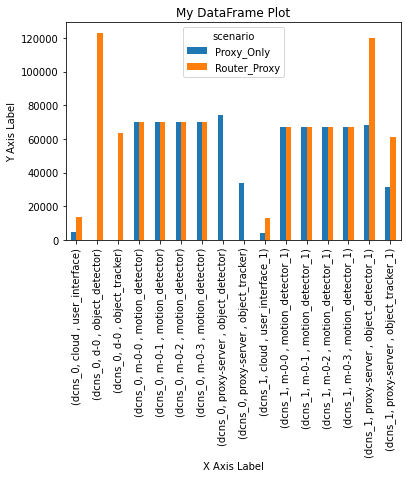

In [21]:
# Customize plot with additional parameters (e.g., title, xlabel, ylabel)
t.plot(kind='bar',title='My DataFrame Plot', xlabel='X Axis Label', ylabel='Y Axis Label')


vm,scenario,app,motion_detector,motion_detector_1,object_detector,object_detector_1,object_tracker,object_tracker_1,user_interface,user_interface_1
0,Proxy_Only,dcns_0,69953.976,NaN,74460.292993,NaN,33896.888726,NaN,4579.821429,NaN
1,Proxy_Only,dcns_1,NaN,66925.438,NaN,68185.408394,NaN,31288.777971,NaN,4030.242857
2,Router_Proxy,dcns_0,69953.976,NaN,123119.366414,NaN,63497.152157,NaN,13373.078571,NaN
3,Router_Proxy,dcns_1,NaN,66925.438,NaN,120191.771860,NaN,60871.946900,NaN,12823.500000


<Axes: >

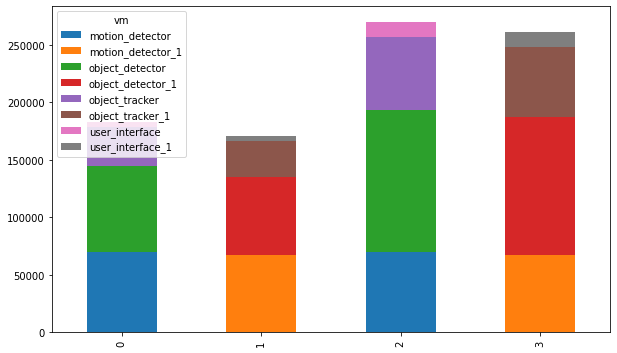

In [22]:
# display and plot
# Pivot the DataFrame to have VMs as columns
pivot_df = computation_energy_per_vm_df.pivot_table(index=['scenario','app'], columns=['vm'], values='energy').reset_index()
display(pivot_df)
# Plotting
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))


In [15]:
_reset()